Install all libraries and prerequisites

In [1]:
# tensorflow packages
%pip install absl-py
%pip install tensorflow
%pip install tensorflow-hub
# seaborn
%pip install seaborn
# ML
%pip install scikit-learn
# Facebook's pytorch
%pip install torch
# Hugging face
%pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Load the libraries

In [2]:
# Normal packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

# Deep learning
from absl import logging
import tensorflow as tf
import tensorflow_hub as hub

# Hugging Face
from transformers import pipeline

# Scikit-learn
from sklearn.cluster import KMeans

# NLP
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
# Download some nltk required data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertgill/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertgill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load the deep Learning NLP Models (pretrained)

In [ ]:
# Universal sentence encoder (from Google)
USE_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Function to use USE encoder
def embed(input):
    return np.array(USE_encoder(input))



In [ ]:
# Get sentiment model from hugging face platform

sentiment_model = pipeline("sentiment-analysis")



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [ ]:
def sentiment(input):
    result = sentiment_model(input[:512])
    sign = 1 if(result[0]['label']=="POSITIVE") else -1
    value = result[0]['score']
    return sign*value

Load the data

In [ ]:
df = pd.read_csv("panekDemoVid.tsv", sep="\t")

df.shape

(336, 8)

In [ ]:
df.sample(10)

,Video Location,YouTube URL,Transcript,Viewers Political Leaning,Unnamed: 4,Unnamed: 5,Raw Leanings,Number
180,O274,https://youtube.com/shorts/xY-6hJY5h4E?si=EQ4i...,Joe Biden is so slow and something is definite...,Center,NaN,NaN,Leaning Conservative,182
277,NaN,NaN,NaN,NaN,NaN,NaN,Leaning Liberal,279
43,E71,https://youtube.com/shorts/NReQ3_WOqJU?si=v808...,Not Available,Conservative,NaN,NaN,Liberal,45
304,NaN,NaN,NaN,NaN,NaN,NaN,Leaning Liberal,306
332,NaN,NaN,NaN,NaN,NaN,NaN,Conservative,334
129,K280,https://youtu.be/rXepkIWPhFQ?si=_HC0Wh7Iyqodtkp8,Good morning everybody. I'd like to talk about...,Leaning Conservative,NaN,NaN,Center,131
284,NaN,NaN,NaN,NaN,NaN,NaN,Leaning Liberal,286
237,S278,https://youtu.be/Qu2OSyMjHMw?si=NFvzHeNCti3kTClV,[Music] so you may or may not know about this ...,Conservative,NaN,NaN,Center,239
133,K336,https://youtu.be/xlvznDgmcJg?si=Z6ensoMG0AUBg0rM,body camera footage has now been released of t...,Center,NaN,NaN,Conservative,135
24,C10,https://youtu.be/bTFKvV2-XSA?si=1xfxFfKG7TMRvdwN,Not Available,Leaning Conservative,NaN,NaN,Center,26


Limit data to reviews we wish to build topics off of

In [ ]:
# Look at only the side effects
Transcript = df['Transcript'].dropna().tolist()



Create topic model

In [ ]:
class ReviewsTopicModel:

    STOPWORDS = stopwords.words('english') # stopwords from ntlk

    EMBEDDING_DIM = 512 # USE encoder

    # Constructor
    def __init__(self, reviews):
        self.X = self.clean(reviews)

    # Clean text method
    def clean(self, reviews):
        # Words to replace
        string_map = {'\r': '', '\n': '', '/': ' ', "'": "", '"': ''}
        reviews_cleaned = reviews[:]
        for i in range(len(reviews_cleaned)):
            for s in string_map:
                reviews_cleaned[i] = reviews_cleaned[i].replace(s, string_map[s]).lower() 
        # Transform the reviews into embeddings dataframe
        X = embed(reviews_cleaned)
        X = pd.DataFrame(X)
        X.index = reviews_cleaned
        return X

    # Method to determine number of topics (a.k.a kmeans cluster number)
    def elbow_plot(self):
        cluster_sizes = list(range(1, 81))
        cluster_scores = []
        for n in cluster_sizes:
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(self.X)
            cluster_scores.append(kmeans.inertia_)
        plt.figure()
        plt.plot(cluster_sizes, cluster_scores)
        plt.show()

    # Method to extract topics from text data
    def create_topics(self, num_topics):
        # Cluster the reviews
        kmeans = KMeans(n_clusters=num_topics)
        kmeans.fit(self.X)

        # Create the final topics dataframe
        topics_df = self.X.copy()
        topics_df['topic'] = kmeans.labels_.copy()
        topics_df['topic'] = topics_df['topic'].astype(int)

        # Create summary keywords per topic
        topic_keywords = {}
        for topic in topics_df['topic'].unique():
            topic_reviews = topics_df.query("topic == {}".format(topic)).index.tolist()
            topic_centroid = kmeans.cluster_centers_[topic] # cluster center
            topic_keywords[topic] = self.get_closest_words(topic_reviews, topic_centroid)
        topics_df['topic_keywords'] = topics_df['topic'].map(topic_keywords)

        # Score the sentiment of each review
        topics_df['sentiment'] = [sentiment(r) for r in topics_df.index.values.tolist()]

        # Final result
        self.topics_keywords = topic_keywords
        self.topics_df = topics_df.copy()[['topic', 'topic_keywords', 'sentiment']]


    def get_closest_words(self, reviews, centroid):
        word_distances = {}
        for r in reviews:
            review_words = [w for w in word_tokenize(r) if(w not in self.STOPWORDS)]
            for w in review_words:
                word_embedding = embed([w]) # return 512 dimensional vector for the word 'w'
                # how similar is the word embedding to the topic's centroid (avg of the cluster sample's embeddings)
                word_distances[w] = self.cosine_similarity(word_embedding, centroid) # 1 it means match, closer to 0 means different
        # done collecting the distances of the words to the topic's center
        top_5_keywords = sorted([(word_distances[w], w) for w in word_distances])[-5:]
        return ",".join([x[1] for x in top_5_keywords])

    def cosine_similarity(self, x, y):
        # x,y are both the appropriate dimension
        x = x.reshape(self.EMBEDDING_DIM,)
        y = y.reshape(self.EMBEDDING_DIM,)
        # calculate cosine similarity
        dotproduct = x.dot(y)
        x_mag = x.dot(x)**0.5
        y_mag = y.dot(y)**0.5
        # returns closer to 1 if x and y are similar, closer to 0 if they are different
        return dotproduct/(x_mag * y_mag)






Initialize model

In [ ]:
topic_model = ReviewsTopicModel(Transcript)

Create elbow plot to determine optimal number of topics (i.e. clusters)

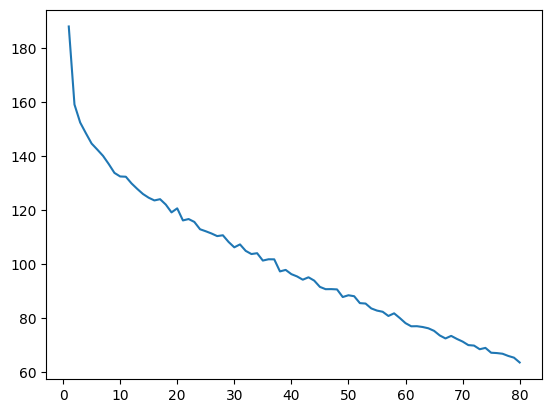

In [ ]:
topic_model.elbow_plot() # going to use 40 clusters i.e. 40 topics

Create final model and evaluate

In [ ]:
topic_model.create_topics(num_topics=40)

In [ ]:
# Print topic keywords for topic 5
print('Topic 5 keywords:', topic_model.topics_keywords[5])

'hurricane,storms,tornado,hurricanes,tornadoes'

In [ ]:
topic_model.topics_df.query("topic == 10")

topic  \
the podcast has to have a theme right and that ...     10   
sam cedar emma vigland on the majority report w...     10   
but i wanted to not get past the free portion o...     10   
came across this clip over the weekend this is ...     10   
hello welcome to cbn news my name is dan andros...     10   
[music] [music] all right hey welcome folks mil...     10   
brits foreign secretary david cameron says that...     10   
[music] i am an active duty member of the unite...     10   

                                                                                       topic_keywords  \
the podcast has to have a theme right and that ...  appeaser,anti-semitism,netanyahu,zionists,pro-...   
sam cedar emma vigland on the majority report w...  appeaser,anti-semitism,netanyahu,zionists,pro-...   
but i wanted to not get past the free portion o...  appeaser,anti-semitism,netanyahu,zionists,pro-...   
came across this clip over the weekend this is ...  appeaser,anti-semitism,netanyahu,zionists,pro-...   
hello welcome to cbn news my name is dan andros...  appeaser,anti-semitism,netanyahu,zionists,pro-...   
[music] [music] all right hey welcome folks mil...  appeaser,anti-semitism,netanyahu,zionists,pro-...   
brits foreign secretary david cameron says that...  appeaser,anti-semitism,netanyahu,zionists,pro-...   
[music] i am an active duty member of the unite...  appeaser,anti-semitism,netanyahu,zionists,pro-...   

                                                    sentiment  
the podcast has to have a theme right and that ...  -0.999745  
sam cedar emma vigland on the majority report w...   0.781308  
but i wanted to not get past the free portion o...  -0.998936  
came across this clip over the weekend this is ...   0.935913  
hello welcome to cbn news my name is dan andros...  -0.713972  
[music] [music] all right hey welcome folks mil...   0.747192  
brits foreign secretary david cameron says that...  -0.998778  
[music] i am an active duty member of the unite...   0.963556

Look at average sentiment per topic

In [ ]:
topic_model.topics_df.groupby(['topic', 'topic_keywords']).agg({'sentiment': 'mean'}).reset_index()\
    .sort_values(by='sentiment')

,topic,topic_keywords,sentiment
2,2,available,-0.999784
6,6,"tenant,investigators,assaulted,deputies,homeowner",-0.997099
29,29,"mice,mouse,million,shoe,shoes",-0.996220
18,18,"presidential,democrats,democrat,trump,bipartis...",-0.995241
33,33,"arbitration,scamming,spamming,robux,discord",-0.990769
11,11,"mcu,avengers,marvel,marvels,feige",-0.990718
28,28,"states,legislation,lawmakers,legislature,const...",-0.990610
7,7,"scamming,toxic,roblox,scammer,robux",-0.987848
38,38,"police,arrest,officer,sheriff,sheriffs",-0.984500
19,19,"caso,qué,quien,esto,estas",-0.982606


In [ ]:
topic_model.topics_df.query("topic == 1")

topic  \
so right now youre under arrest for theft for w...      1   
so good morning everyone my name is judge barba...      1   
i pushed him i said bro what the f are you doin...      1   
lally in front of my house right now that shs a...      1   
they made it clear that i was different unusual...      1   
on march 7th 2023 an officer was called by scho...      1   
karens are the worst type of people to face but...      1   
hello hello its patty joe i am sorry its been l...      1   
every time i come my brother be retired highway...      1   
i never thought that these words would leave my...      1   
and by the way now youre taking a picture of in...      1   
on june 17th 2022 law enforcement responded to ...      1   
all right youre in your driveway you got some v...      1   
[music] we are at the miami seport its one of t...      1   
from thinking that they could bully their way o...      1   

                                                                                      topic_keywords  \
so right now youre under arrest for theft for w...  restraining,detained,disorderly,arrest,arresting   
so good morning everyone my name is judge barba...  restraining,detained,disorderly,arrest,arresting   
i pushed him i said bro what the f are you doin...  restraining,detained,disorderly,arrest,arresting   
lally in front of my house right now that shs a...  restraining,detained,disorderly,arrest,arresting   
they made it clear that i was different unusual...  restraining,detained,disorderly,arrest,arresting   
on march 7th 2023 an officer was called by scho...  restraining,detained,disorderly,arrest,arresting   
karens are the worst type of people to face but...  restraining,detained,disorderly,arrest,arresting   
hello hello its patty joe i am sorry its been l...  restraining,detained,disorderly,arrest,arresting   
every time i come my brother be retired highway...  restraining,detained,disorderly,arrest,arresting   
i never thought that these words would leave my...  restraining,detained,disorderly,arrest,arresting   
and by the way now youre taking a picture of in...  restraining,detained,disorderly,arrest,arresting   
on june 17th 2022 law enforcement responded to ...  restraining,detained,disorderly,arrest,arresting   
all right youre in your driveway you got some v...  restraining,detained,disorderly,arrest,arresting   
[music] we are at the miami seport its one of t...  restraining,detained,disorderly,arrest,arresting   
from thinking that they could bully their way o...  restraining,detained,disorderly,arrest,arresting   

                                                    sentiment  
so right now youre under arrest for theft for w...  -0.998400  
so good morning everyone my name is judge barba...   0.731439  
i pushed him i said bro what the f are you doin...  -0.993022  
lally in front of my house right now that shs a...   0.994737  
they made it clear that i was different unusual...  -0.994997  
on march 7th 2023 an officer was called by scho...  -0.998924  
karens are the worst type of people to face but...  -0.997825  
hello hello its patty joe i am sorry its been l...  -0.996922  
every time i come my brother be retired highway...  -0.996938  
i never thought that these words would leave my...   0.964004  
and by the way now youre taking a picture of in...  -0.955436  
on june 17th 2022 law enforcement responded to ...  -0.995953  
all right youre in your driveway you got some v...  -0.998874  
[music] we are at the miami seport its one of t...  -0.957891  
from thinking that they could bully their way o...  -0.993530